In [1]:
%reset -f
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle, time, os
from datetime import timedelta

In [2]:
t = time.time()
#path = os.getcwd()
path = r'/home/d/dlr10/Documents/01_Preprocessing/00_Data_2016_2018/DataFrame_pickles'
df_patients, df_admissions = pickle.load(open(path + '/df_patients_admissions_2016_2018_v2.pickle', 'rb'))
df_eobs, df_oxyge          = pickle.load(open(path + '/df_eobs_oxygen_2016_2018_v2.pickle', 'rb'))
print('Time elapsed loading data: ', time.time() - t)

Time elapsed loading data:  9.330333948135376


# Admissions

In [3]:
df_admin_new = df_admissions[(df_admissions['lengthofstay'].dt.days >= 3) & (df_admissions['no_obs_eobs'] > 5) &
                            (df_admissions['no_obs_eobs'] < 200) & (df_admissions['isPneumonia'] == 1)]
df_admin_new = df_admin_new.drop(columns = ['admission_date_code_time', 'discharge_date_code_time', 'icu_count\r'])
df_admin_new['lengthofstay'] = df_admin_new['lengthofstay'].dt.days

df_admin_new = df_admin_new.rename(columns ={'age_at_admission\r':'age_at_admin', 'mortal_admin':'Mortality'})

lst_admins   = df_admin_new['admission_id'].unique().tolist()


ls_adm_1 = df_admin_new[df_admin_new['Mortality'] == 1]['admission_id'].unique().tolist()
ls_adm_0 = df_admin_new[df_admin_new['Mortality'] == 0]['admission_id'].unique().tolist()
print(len(df_admin_new))
display(df_admin_new.head(4))

13854


,admission_id,episode_diagnoses,patient_id,age_at_admin,admission_date_time,discharge_date_time,lengthofstay,isPneumonia,Mortality,Comorbidity_score,no_obs_eobs
4,92464775,"||J18.1,N17.9,F05.9,J90.X,R33.X,G20.X,R63.8,E1...",18544317,91,2018-03-11 18:20:00,2018-03-16 18:00:00,4,1,1,6,45
5,74554266,"||J18.9,E87.1,A09.0,R11.X,I10.X,M10.9,C91.1,F3...",42309321,72,2018-02-19 07:58:00,2018-02-23 18:00:00,4,1,0,0,17
6,67812046,"||J45.9,J18.9,F17.1||J45.9,J18.9,F17.1",80081107,40,2018-01-05 13:14:00,2018-01-09 16:15:00,4,1,0,0,18
7,78793793,"||J18.1,E16.0,Y42.3,E11.9,F03.X,E53.8,I10.X,I4...",53480739,88,2017-07-06 17:40:00,2017-07-10 20:49:00,4,1,1,9,32


NUMBER OF OBSERVATIONS IN EOBS


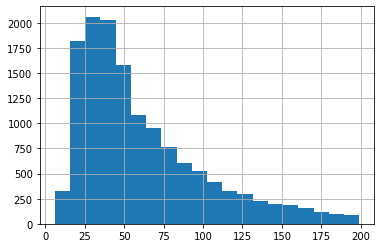

DECEASED
Space per bin 3.86


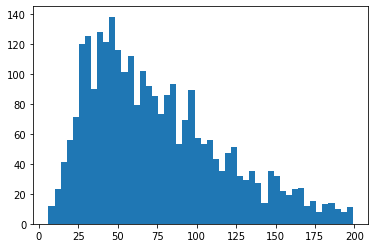


DISCHARGED
Space per bin 3.86


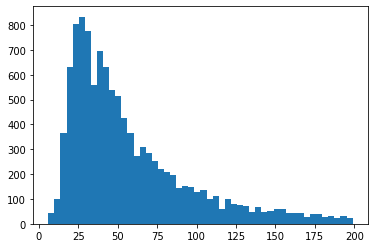

In [4]:
bins_ =20
print("NUMBER OF OBSERVATIONS IN EOBS")
df = df_admin_new.copy()
df['no_obs_eobs'].hist(bins = bins_)
(df['no_obs_eobs'].max() - df['no_obs_eobs'].min())/ bins_
plt.show()

print("DECEASED")
x = df_admin_new[(df_admin_new['admission_id'].isin(ls_adm_1))]['no_obs_eobs']
plt.hist(x, bins = 50)
#plt.savefig('no_eobs_obs.png', transparent = True, bbox_inches = "tight")
print("Space per bin", (x.max() - x.min() )/50)
plt.show()

print("")
print("DISCHARGED")
x = df_admin_new[(df_admin_new['admission_id'].isin(ls_adm_0))]['no_obs_eobs']
plt.hist(x, bins = 50)
print("Space per bin", (x.max() - x.min() )/50)
plt.show()

# E-Obs

In [5]:
print(len(df_eobs))
def minutes_from_deltatime(x):
    mins_days = x.days * 24 * 60
    mins_secs = int(x.seconds/60)
    mins_ = mins_days + mins_secs
    return mins_

1137181


In [6]:
t = time.time()

delta_3days = timedelta(days=3)

df_eobs_new = df_eobs[df_eobs['admission_id'].isin(lst_admins)].copy()
df_eobs_new = df_eobs_new.rename(columns={'temperature\r':'temperature'})
df_eobs_new['time_since_prev_obs_in_mins'] = pd.to_timedelta(df_eobs_new['time_since_prev_obs_in_mins'])
df_eobs_new['gaps'] = df_eobs_new['time_since_prev_obs_in_mins'].apply(lambda x: minutes_from_deltatime(x))
df_eobs_new = df_eobs_new[df_eobs_new['gaps'] < 1440]

lst_adm_eobs = df_eobs_new['admission_id'].unique().tolist()

print('Time elapsed processing EOBS data: ', time.time() - t)

Time elapsed processing EOBS data:  9.423056364059448


In [7]:
t = time.time()

df_eobs_new2 = pd.DataFrame(columns = df_eobs_new.columns)
print("length eobs:",len(df_eobs_new))
print("ADMINS IN EOBS", len(lst_adm_eobs))
for i, admin in enumerate(lst_adm_eobs):
    adm = df_admin_new[df_admin_new['admission_id'] == admin]
    #print("length of stay:", adm['lengthofstay'].iloc[0])
    df = df_eobs_new[(df_eobs_new['admission_id'] == admin)]
    ini_time = df.iloc[0]['timestamp'] 
    fin_time = ini_time + delta_3days
    df_ = df[(df['timestamp'] <=  fin_time)].sort_values(by=['timestamp'])
    df_['gaps_cum'] = df_['gaps'].cumsum()
    df_['ts_gap']   = df_['gaps_cum'].apply(lambda x: int(x/30))
    
    df_eobs_new2 = pd.concat([df_eobs_new2 , df_])
    
    if i % 2000 == 0: print("PROCESSED ", i, " admissions")
print("length eobs:",len(df_eobs_new2))

display(df_eobs_new2.head(4))
print('Time elapsed processing EOBS data: ', time.time() - t)

length eobs: 843473
ADMINS IN EOBS 13854
PROCESSED  0  admissions
PROCESSED  2000  admissions
PROCESSED  4000  admissions
PROCESSED  6000  admissions
PROCESSED  8000  admissions
PROCESSED  10000  admissions
PROCESSED  12000  admissions
length eobs: 304276


,admission_id,patient_id,timestamp,time_since_prev_obs_in_mins,rr,ews,heart_rate,temperature,timestamp_code,sbp,dbp,gaps,gaps_cum,ts_gap
28118,92464775,18544317,2018-03-11 12:19:13,0 days 00:00:00,23,11,97.0,37.0,17601.513345,83.0,40.0,0,0.0,0.0
28119,92464775,18544317,2018-03-11 12:34:32,0 days 00:15:19,20,8,77.0,36.7,17601.523981,75.0,57.0,15,15.0,0.0
28120,92464775,18544317,2018-03-11 13:10:21,0 days 00:35:49,20,6,74.0,36.8,17601.548854,81.0,71.0,35,50.0,1.0
28121,92464775,18544317,2018-03-11 14:00:54,0 days 00:50:33,19,4,75.0,36.8,17601.583958,96.0,60.0,50,100.0,3.0


Time elapsed processing EOBS data:  657.6400632858276


In [8]:
df_eobs_new = df_eobs_new2.reset_index(drop= True).copy()

#### DISTRIBUTION OF GAPS IN EOBS

DECEASED Space per bin 28.64

DISCHARGED Space per bin 28.62


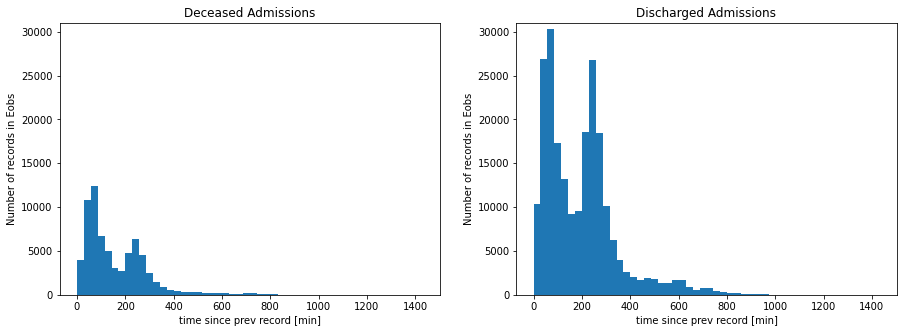

In [9]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

d = timedelta(seconds=0)

x = df_eobs_new[(df_eobs_new['admission_id'].isin(ls_adm_1)) & (df_eobs_new['time_since_prev_obs_in_mins'] != d)]['gaps']
print("DECEASED Space per bin", (x.max() - x.min() )/50)
ax[0].hist(x, bins = 50)
ax[0].set_title('Deceased Admissions')
ax[0].set_ylabel('Number of records in Eobs')
ax[0].set_xlabel('time since prev record [min]')
ax[0].set_ylim([0,31000])

print("")
x = df_eobs_new[(df_eobs_new['admission_id'].isin(ls_adm_0)) & (df_eobs_new['time_since_prev_obs_in_mins'] != d)]['gaps']
print("DISCHARGED Space per bin", (x.max() - x.min() )/50)
ax[1].hist(x, bins = 50)
ax[1].set_title('Discharged Admissions')
ax[1].set_ylabel('Number of records in Eobs')
ax[1].set_xlabel('time since prev record [min]')
ax[1].set_ylim([0,31000])
plt.savefig('sampling_frequency.png', transparent = True, bbox_inches = "tight")
plt.show()

#### DISTRIBUTION OF NUMBER OF OBSERVATIONS IN EOBS

Time elapsed processing EOBS data:  325.7507121562958
DECEASED Space per bin 1.66

DISCHARGED Space per bin 1.72


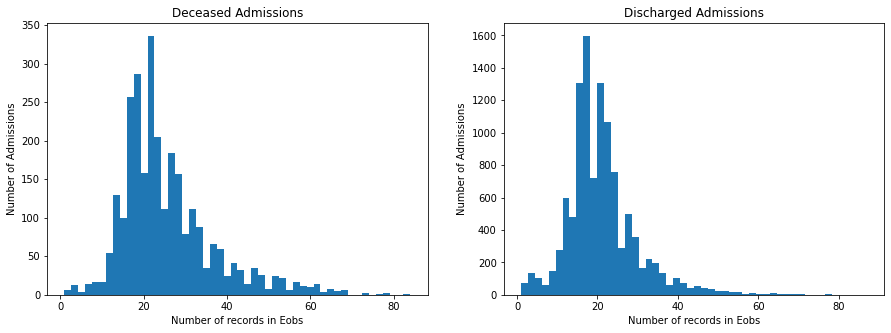

In [10]:
lst_adm_eobs = df_eobs_new['admission_id'].unique().tolist()
ls_adm_eobs_1 = list(set(lst_adm_eobs) & set(ls_adm_1))
ls_adm_eobs_0 = list(set(lst_adm_eobs) & set(ls_adm_0))
t = time.time()
df_admin_new['no_obs_eobs'] = [len(df_eobs_new[df_eobs_new['admission_id'] == adm ])
                                           for adm in df_admin_new['admission_id'].unique().tolist()]
print('Time elapsed processing EOBS data: ', time.time() - t)

fig, ax = plt.subplots(1,2, figsize = (15,5))
x = df_admin_new[(df_admin_new['admission_id'].isin(ls_adm_eobs_1))]['no_obs_eobs']
print("DECEASED Space per bin", (x.max() - x.min() )/50)
ax[0].hist(x, bins = 50)
ax[0].set_title('Deceased Admissions')
ax[0].set_ylabel('Number of Admissions')
ax[0].set_xlabel('Number of records in Eobs')
#ax[0].set_ylim([0,31000])

print("")
x = df_admin_new[(df_admin_new['admission_id'].isin(ls_adm_eobs_0))]['no_obs_eobs']
print("DISCHARGED Space per bin", (x.max() - x.min() )/50)
ax[1].hist(x, bins = 50)
ax[1].set_title('Discharged Admissions')
ax[1].set_ylabel('Number of Admissions')
ax[1].set_xlabel('Number of records in Eobs')
#ax[1].set_ylim([0,31000])
plt.show()

# Defining abnormal signals

In [11]:
dict_sypmt_min_max = {'rr':[5, 40], 'heart_rate':[20,160], 'temperature\r':[30, 45],'sbp': [60,200], 'dbp':[40,120],
                 'Oxygen_Saturation':[60,100], 'ews':[0,21]}

dict_sympt_intv = {'rr':[12, 25], 'heart_rate':[60,100], 'temperature':[36, 38],'sbp': [90,120], 'dbp':[60,80],
                 'Oxygen_Saturation':[85,100], 'ews':[0,21], 'UREA':[6, 24]}


df_admin_new
df_eobs_new
feature = 'rr'

In [12]:
df_out_clinic_interval = df_eobs_new[(dict_sympt_intv[feature][0] > df_eobs_new[feature]) | 
                                        (dict_sympt_intv[feature][1] < df_eobs_new[feature])]
df_in_clinic_interval  = df_eobs_new[~(dict_sympt_intv[feature][0] > df_eobs_new[feature]) & 
                                        ~(dict_sympt_intv[feature][1] < df_eobs_new[feature])]

admins_out_df = df_out_clinic_interval['admission_id'].unique().tolist()
admins_in_df  = df_in_clinic_interval['admission_id'].unique().tolist()
print(len(admins_out_df))
print(len(admins_in_df))

4225
13834


In [13]:
#ls_adms_1 = list(set(admins_df) & set(ls_adm_1))
#ls_adms_0 = list(set(admins_df) & set(ls_adm_0))
#print(len(ls_adms_1))
#print(len(ls_adms_0))

In [14]:
len(df_eobs_new['admission_id'].unique().tolist())

13854

In [15]:
t = time.time()

def get_abnormal_admins_for_feature(feature ):
    lst_adm_eobs = df_eobs_new['admission_id'].unique().tolist()
    adm_tot_abn = []
    adm_tot_nor = []
    adm_par_abn = []
    dict_abn_ad = {}
    for i, adm in enumerate(lst_adm_eobs):
        df_temp = df_eobs_new[df_eobs_new['admission_id'] == adm]
        df_temp_0 = df_temp[(dict_sympt_intv[feature][0] > df_temp[feature]) | (dict_sympt_intv[feature][1] < df_temp[feature])]
        nu_abn_elm = len(df_temp_0)
        dict_abn_ad[adm] = nu_abn_elm

        if (nu_abn_elm == len(df_temp)) and (nu_abn_elm != 0):
            adm_tot_abn.append(adm)
        elif nu_abn_elm == 0:
            adm_tot_nor.append(adm)
        else:
            adm_par_abn.append(adm)
        if i % 2000 == 0: print(feature, "PROCESSED ", i, " admissions in", time.time() - t)
    return adm_tot_abn, adm_tot_nor, adm_par_abn, dict_abn_ad
            
adm_tot_abn, adm_tot_nor, adm_par_abn, dict_abn_ad = get_abnormal_admins_for_feature(feature)
    
print('Time elapsed processing EOBS data: ', time.time() - t)

rr PROCESSED  0  admissions in 0.050405025482177734
rr PROCESSED  2000  admissions in 47.09987998008728
rr PROCESSED  4000  admissions in 94.66748809814453
rr PROCESSED  6000  admissions in 142.75627398490906
rr PROCESSED  8000  admissions in 191.68298482894897
rr PROCESSED  10000  admissions in 238.4373116493225
rr PROCESSED  12000  admissions in 285.2181372642517
Time elapsed processing EOBS data:  328.8679678440094


In [16]:
print(len(adm_tot_abn))
print(len(adm_tot_nor))
print(len(adm_par_abn))
print(len(adm_par_abn) + len(adm_tot_nor) + len(adm_tot_abn))
#len(dict_abn_ad)

20
9629
4205
13854


In [17]:
adm_tot_abn_1 = list(set(adm_tot_abn) & set(ls_adm_1))
adm_tot_abn_0 = list(set(adm_tot_abn) & set(ls_adm_0))

adm_tot_nor_1 = list(set(adm_tot_nor) & set(ls_adm_1))
adm_tot_nor_0 = list(set(adm_tot_nor) & set(ls_adm_0))

adm_par_abn_1 = list(set(adm_par_abn) & set(ls_adm_1))
adm_par_abn_0 = list(set(adm_par_abn) & set(ls_adm_0))

df_lst = [[len(adm_tot_abn_0), len(adm_tot_nor_0), len(adm_par_abn_0)], 
          [len(adm_tot_abn_1), len(adm_tot_nor_1), len(adm_par_abn_1)]]
pd.DataFrame(df_lst, columns = ['tot_abn', 'tot_nor','par_abn'], index = ['0','1'])

,tot_abn,tot_nor,par_abn
0,17,8001,3036
1,3,1628,1169


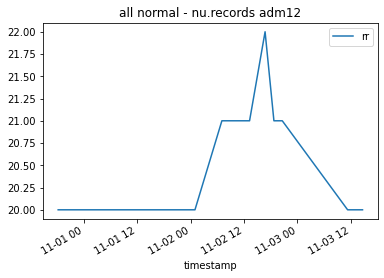

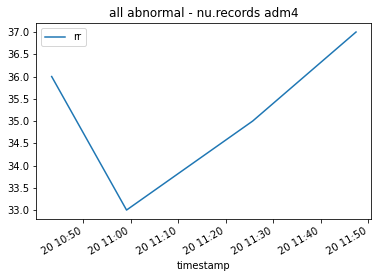

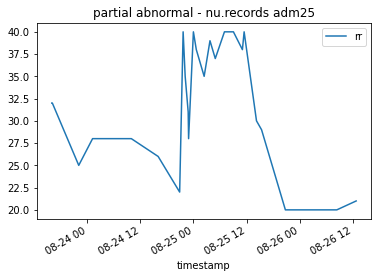

In [18]:
adm = adm_tot_nor_0[0]
df_eobs_new[df_eobs_new['admission_id'] == adm].plot(x ='timestamp', y = feature)
plt.title("all normal - nu.records adm" + str(len(df_eobs_new[df_eobs_new['admission_id'] == adm])))
plt.show()

adm = adm_tot_abn_0[0]
df_eobs_new[df_eobs_new['admission_id'] == adm].plot(x ='timestamp', y = feature)
plt.title("all abnormal - nu.records adm" + str(len(df_eobs_new[df_eobs_new['admission_id'] == adm])))
plt.show()

adm = adm_par_abn_0[0]
df_eobs_new[df_eobs_new['admission_id'] == adm].plot(x ='timestamp', y = feature)
plt.title("partial abnormal - nu.records adm" + str(len(df_eobs_new[df_eobs_new['admission_id'] == adm])))
plt.show()

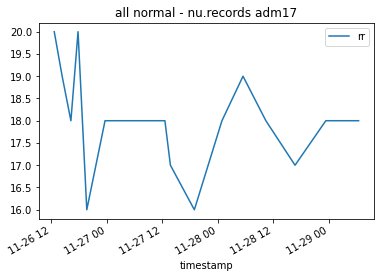

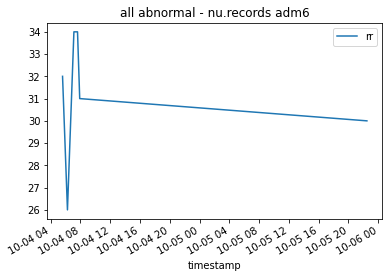

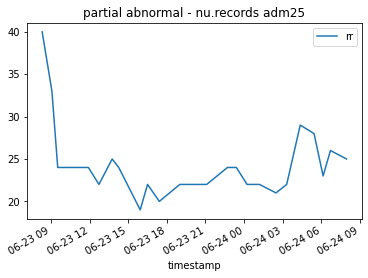

In [19]:
adm = adm_tot_nor_1[0]
df_eobs_new[df_eobs_new['admission_id'] == adm].plot(x ='timestamp', y = feature)
plt.title("all normal - nu.records adm" + str(len(df_eobs_new[df_eobs_new['admission_id'] == adm])))
plt.show()

adm = adm_tot_abn_1[0]
df_eobs_new[df_eobs_new['admission_id'] == adm].plot(x ='timestamp', y = feature)
plt.title("all abnormal - nu.records adm" + str(len(df_eobs_new[df_eobs_new['admission_id'] == adm])))
plt.show()

adm = adm_par_abn_1[0]
df_eobs_new[df_eobs_new['admission_id'] == adm].plot(x ='timestamp', y = feature)
plt.title("partial abnormal - nu.records adm" + str(len(df_eobs_new[df_eobs_new['admission_id'] == adm])))
plt.show()

rr PROCESSED  0  admissions in 0.05927109718322754
rr PROCESSED  2000  admissions in 49.04112648963928
rr PROCESSED  4000  admissions in 91.53158712387085
rr PROCESSED  6000  admissions in 135.38350629806519
rr PROCESSED  8000  admissions in 176.20916438102722
rr PROCESSED  10000  admissions in 217.24531054496765
rr PROCESSED  12000  admissions in 259.35405015945435
################ rr ################


,tot_abn,tot_nor,par_abn
0,17,8001,3036
1,3,1628,1169


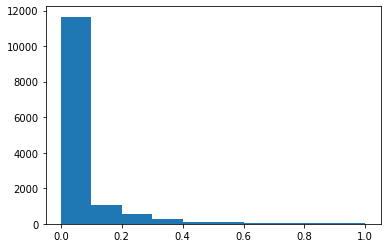

heart_rate PROCESSED  0  admissions in 301.66776728630066
heart_rate PROCESSED  2000  admissions in 341.82163548469543
heart_rate PROCESSED  4000  admissions in 383.54782915115356
heart_rate PROCESSED  6000  admissions in 425.0973811149597
heart_rate PROCESSED  8000  admissions in 467.52337527275085
heart_rate PROCESSED  10000  admissions in 513.6248817443848
heart_rate PROCESSED  12000  admissions in 557.5054879188538
################ heart_rate ################


,tot_abn,tot_nor,par_abn
0,102,3061,7891
1,33,573,2194


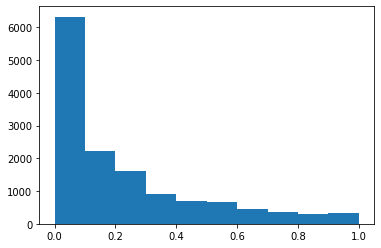

temperature PROCESSED  0  admissions in 602.0323040485382
temperature PROCESSED  2000  admissions in 646.7828476428986
temperature PROCESSED  4000  admissions in 692.5800271034241
temperature PROCESSED  6000  admissions in 737.1686644554138
temperature PROCESSED  8000  admissions in 779.3062903881073
temperature PROCESSED  10000  admissions in 828.6711568832397
temperature PROCESSED  12000  admissions in 874.2809634208679
################ temperature ################


,tot_abn,tot_nor,par_abn
0,22,5058,5974
1,5,1250,1545


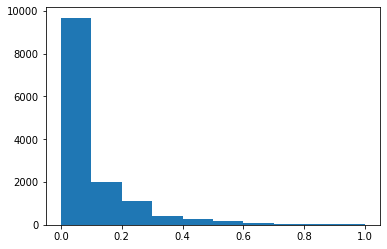

sbp PROCESSED  0  admissions in 918.2626168727875
sbp PROCESSED  2000  admissions in 958.054630279541
sbp PROCESSED  4000  admissions in 998.6865835189819
sbp PROCESSED  6000  admissions in 1038.9334874153137
sbp PROCESSED  8000  admissions in 1078.889152288437
sbp PROCESSED  10000  admissions in 1121.478370666504
sbp PROCESSED  12000  admissions in 1165.4538156986237
################ sbp ################


,tot_abn,tot_nor,par_abn
0,1153,181,9720
1,225,34,2541


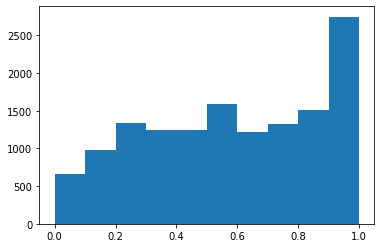

dbp PROCESSED  0  admissions in 1205.9067475795746
dbp PROCESSED  2000  admissions in 1248.0160098075867
dbp PROCESSED  4000  admissions in 1288.2296042442322
dbp PROCESSED  6000  admissions in 1334.8583195209503
dbp PROCESSED  8000  admissions in 1387.4009220600128
dbp PROCESSED  10000  admissions in 1438.50385928154
dbp PROCESSED  12000  admissions in 1487.1800813674927
################ dbp ################


,tot_abn,tot_nor,par_abn
0,126,174,10754
1,20,14,2766


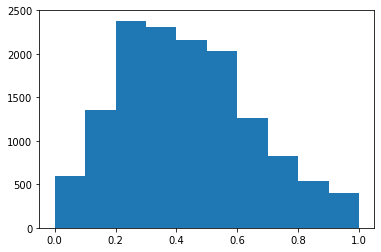

Time elapsed :  1531.9125533103943


In [20]:
###################################################################
# ADDING ABNORMALITY TO ADMISSIONS DF OF ALL FEATURES
###################################################################

def get_group_of_admin(x, lst_groups_, lst_names_):
    group = 0
    for i in range(len(lst_groups_)):
          if x in lst_groups_[i]:
                group = lst_names_[i]
                break
    return group
t = time.time()

features = ['rr', 'heart_rate', 'temperature', 'sbp', 'dbp']

for feature in features:
    adm_tot_abn, adm_tot_nor, adm_par_abn, dict_abn_ad = get_abnormal_admins_for_feature(feature)

    adm_tot_abn_1 = list(set(adm_tot_abn) & set(ls_adm_1))
    adm_tot_abn_0 = list(set(adm_tot_abn) & set(ls_adm_0))

    adm_tot_nor_1 = list(set(adm_tot_nor) & set(ls_adm_1))
    adm_tot_nor_0 = list(set(adm_tot_nor) & set(ls_adm_0))

    adm_par_abn_1 = list(set(adm_par_abn) & set(ls_adm_1))
    adm_par_abn_0 = list(set(adm_par_abn) & set(ls_adm_0))

    df_lst = [[len(adm_tot_abn_0), len(adm_tot_nor_0), len(adm_par_abn_0)], 
              [len(adm_tot_abn_1), len(adm_tot_nor_1), len(adm_par_abn_1)]]
    print("################", feature, "################")
    display(pd.DataFrame(df_lst, columns = ['tot_abn', 'tot_nor','par_abn'], index = ['0','1']))

    lst_names  = ['tot_abn_0', 'tot_nor_0', 'par_abn_0', 'tot_abn_1', 'tot_nor_1', 'par_abn_1']
    lst_groups = [adm_tot_abn_0, adm_tot_nor_0, adm_par_abn_0, adm_tot_abn_1, adm_tot_nor_1, adm_par_abn_1]
    df_admin_new['abnormality_' + feature] = df_admin_new['admission_id'].apply(lambda x: get_group_of_admin(x, lst_groups, lst_names))
    df_admin_new['abn_prop_' + feature] =  df_admin_new[['admission_id', 'no_obs_eobs']].apply(lambda x: dict_abn_ad[x['admission_id']]/x['no_obs_eobs'], axis = 1)
    
    df_admin_new['abn_prop_' + feature].hist(bins = 10, grid = False)
    
    plt.savefig('abnormal_prop_'+feature+'.png', transparent = True, bbox_inches = "tight")
    plt.show()

print('Time elapsed : ', time.time() - t)

In [21]:
df_admin_new.head(10)

,admission_id,episode_diagnoses,patient_id,age_at_admin,admission_date_time,discharge_date_time,lengthofstay,isPneumonia,Mortality,Comorbidity_score,...,abnormality_rr,abn_prop_rr,abnormality_heart_rate,abn_prop_heart_rate,abnormality_temperature,abn_prop_temperature,abnormality_sbp,abn_prop_sbp,abnormality_dbp,abn_prop_dbp
4,92464775,"||J18.1,N17.9,F05.9,J90.X,R33.X,G20.X,R63.8,E1...",18544317,91,2018-03-11 18:20:00,2018-03-16 18:00:00,4,1,1,6,...,par_abn_1,0.230769,par_abn_1,0.153846,par_abn_1,0.205128,par_abn_1,0.512821,par_abn_1,0.666667
5,74554266,"||J18.9,E87.1,A09.0,R11.X,I10.X,M10.9,C91.1,F3...",42309321,72,2018-02-19 07:58:00,2018-02-23 18:00:00,4,1,0,0,...,tot_nor_0,0.000000,par_abn_0,0.153846,par_abn_0,0.076923,par_abn_0,0.461538,tot_nor_0,0.000000
6,67812046,"||J45.9,J18.9,F17.1||J45.9,J18.9,F17.1",80081107,40,2018-01-05 13:14:00,2018-01-09 16:15:00,4,1,0,0,...,tot_nor_0,0.000000,par_abn_0,0.214286,par_abn_0,0.071429,par_abn_0,0.785714,par_abn_0,0.500000
7,78793793,"||J18.1,E16.0,Y42.3,E11.9,F03.X,E53.8,I10.X,I4...",53480739,88,2017-07-06 17:40:00,2017-07-10 20:49:00,4,1,1,9,...,tot_nor_1,0.000000,par_abn_1,0.083333,par_abn_1,0.083333,par_abn_1,0.416667,par_abn_1,0.875000
8,30248532,"||S72.00,W19.1,F05.1,J18.1,Y95.X,A41.9,K59.0,R...",66238129,86,2017-04-22 18:36:00,2017-05-04 20:40:00,12,1,0,1,...,tot_nor_0,0.000000,par_abn_0,0.033333,par_abn_0,0.033333,par_abn_0,0.700000,par_abn_0,0.533333
9,81444331,"||F03.X,F05.9,E86.X,N17.9,R00.1,R55.X,Z87.4,Z8...",66238129,86,2017-10-30 06:53:00,2017-11-17 16:30:00,18,1,1,4,...,tot_nor_1,0.000000,par_abn_1,0.357143,par_abn_1,0.214286,par_abn_1,0.571429,par_abn_1,0.285714
11,42566860,"||S72.00,W19.1,J18.9,F03.X,Z86.6,Z86.7",66238129,85,2016-07-22 03:21:00,2016-07-28 16:49:00,6,1,0,1,...,tot_nor_0,0.000000,tot_nor_0,0.000000,tot_nor_0,0.000000,par_abn_0,0.818182,par_abn_0,0.454545
14,43167535,"||J18.1,A41.9,R65.1,N17.9,N18.9,E11.2 D,N08.3 ...",59390959,89,2018-05-18 00:49:00,2018-05-22 19:00:00,4,1,0,4,...,tot_nor_0,0.000000,par_abn_0,0.083333,tot_nor_0,0.000000,par_abn_0,0.416667,par_abn_0,0.583333
15,6483250,"||A41.9,R65.1,J18.9,N17.9,N18.9,E86.X,E11.9,J9...",59390959,89,2018-05-31 11:27:00,2018-06-10 17:30:00,10,1,0,9,...,tot_nor_0,0.000000,par_abn_0,0.086957,tot_nor_0,0.000000,par_abn_0,0.391304,par_abn_0,0.478261
16,43986838,"||J18.9,A41.9,N17.9,C34.9,R29.6,F03.X,I10.X,E1...",59390959,89,2018-10-23 01:56:00,2018-11-12 18:00:00,20,1,0,6,...,par_abn_0,0.100000,par_abn_0,0.300000,tot_nor_0,0.000000,par_abn_0,0.650000,par_abn_0,0.300000


In [22]:
t = time.time()
size_gap = 28.65
z = []
for i in range(50):
    for j in range(144):
        df_temp = df_eobs_new[(df_eobs_new['gaps'] >= i * size_gap) & (df_eobs_new['gaps'] < (i+1) * size_gap) &
                   (df_eobs_new['ts_gap'] == j)]
        z.append(len(df_temp))
print('Time elapsed : ', time.time() - t)

Time elapsed :  283.413791179657


In [23]:
z_n = z.copy()
z_n[0] = z_n[0] - len(df_eobs_new['admission_id'].unique())
z_n

[1599,
 592,
 724,
 645,
 545,
 445,
 417,
 352,
 319,
 275,
 212,
 218,
 191,
 165,
 173,
 160,
 130,
 171,
 147,
 114,
 124,
 106,
 107,
 108,
 90,
 73,
 89,
 77,
 73,
 62,
 76,
 71,
 93,
 81,
 66,
 75,
 84,
 64,
 55,
 72,
 79,
 73,
 80,
 83,
 54,
 62,
 74,
 83,
 63,
 69,
 64,
 75,
 62,
 66,
 68,
 50,
 56,
 55,
 58,
 63,
 52,
 70,
 65,
 46,
 46,
 44,
 84,
 55,
 59,
 43,
 49,
 43,
 53,
 55,
 40,
 51,
 32,
 46,
 63,
 50,
 52,
 47,
 58,
 53,
 45,
 44,
 48,
 59,
 55,
 51,
 42,
 51,
 38,
 54,
 44,
 35,
 56,
 40,
 50,
 49,
 39,
 33,
 45,
 40,
 44,
 33,
 40,
 48,
 47,
 31,
 44,
 41,
 34,
 43,
 39,
 49,
 45,
 29,
 40,
 36,
 53,
 40,
 30,
 32,
 39,
 36,
 39,
 28,
 36,
 37,
 44,
 50,
 42,
 51,
 45,
 48,
 52,
 39,
 40,
 47,
 45,
 39,
 34,
 15,
 81,
 3270,
 1064,
 1355,
 1253,
 1168,
 1067,
 988,
 927,
 842,
 760,
 684,
 667,
 624,
 601,
 545,
 495,
 499,
 440,
 425,
 410,
 376,
 364,
 347,
 323,
 322,
 296,
 327,
 287,
 292,
 283,
 273,
 241,
 274,
 233,
 227,
 260,
 253,
 244,
 250,
 239,
 238

In [24]:
x = np.arange(50)
y = np.arange(144)



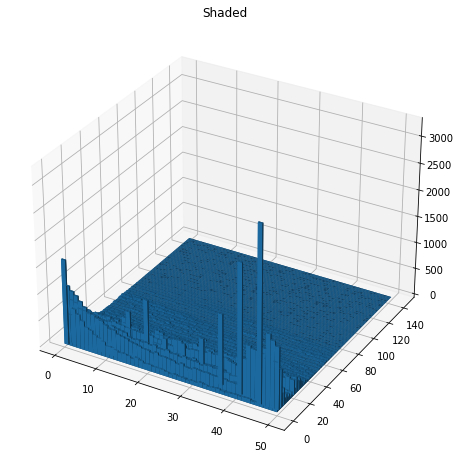

In [25]:
fig = plt.figure(figsize=(8, 8))
ax1 = plt.axes( projection='3d')

_x = np.arange(50)
_y = np.arange(144)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()

#top = x + y

top = z_n
bottom = np.zeros_like(top)
width = depth = 1
ax1.bar3d(x, y, bottom, width, depth, top, shade=True)
ax1.set_title('Shaded')
plt.show()

In [34]:
print(len(x))
print(len(y))
import plotly.graph_objects as go
df = pd.DataFrame(list(zip(*(x,y,z_n))), columns=['TimeseriesStep','interval_next_sample','No_Samples'])
df = df.pivot(index='TimeseriesStep', columns='interval_next_sample', values='No_Samples')

fig = go.Figure(data=[go.Surface(z=df.values)])

fig.update_layout(title='', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90)
                 )
fig.update_layout( yaxis = dict(tickmode = 'linear',
                              tick0 = 0, dtick = 28.65))

fig.show()

7200
7200
